In [2]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../mermaid'))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg
ds = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./files/",
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=500
)
import numpy as np
images = []
for _, batch in enumerate(ds):
    label = np.array(batch[1])
    batch_nines = label==9
    images.append(np.array(batch[0])[batch_nines])
images = np.concatenate(images)

ds = torch.utils.data.TensorDataset(torch.Tensor(images))
d1, d2 = (torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True, ) for _ in (1,1))



Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings_comments.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings_comments.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings_comments.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/democonf_settings.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packa

In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        
        return self.conv6(x)


class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        parameters = pars.ParameterDict()
        parameters.load_JSON("mermaid_config2.json")
        self.sz = np.array([128, 1, 28, 28])
        self.spacing = 1./(self.sz[2::]-1) 
        mf = py_mf.ModelFactory(self.sz, self.spacing, self.sz, self.spacing)
        net, loss = mf.create_registration_model(
            'lddmm_shooting_map', parameters["model"])
        net.computer_inverse_map = True
        loss.add_similarity_measure("ssd", smf.SSDSimilarity)

        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
        self.mermaid_unit = net.cuda()
        self.mermaid_loss = loss
        
        self.regis_net = RegisNet().cuda()
        

    def forward(self, moving_image, fixed_image):
        
        #modify self.mermaid_unit.m here
        m = self.regis_net(moving_image, fixed_image)
        self.mermaid_unit.m = m
        self.mermaid_loss.m = m
        
        #this call modifies self.phi
        self.warped_moving_image = self.__mermaid_shoot__(moving_image)
        
        all_loss, sim_loss, reg_loss = self.mermaid_loss(
            self.identityMap, 
            self.phi,
            moving_image,
            fixed_image,
            None,
            variables_from_forward_model=self.mermaid_unit.get_variables_to_transfer_to_loss_function(),
            variables_from_optimizer=None
        )
        self.loss_dict = {
            'all_loss': all_loss / self.sz[0],
            'sim_loss': sim_loss / self.sz[0],
            'reg_loss': reg_loss / self.sz[0]
        }

    def __mermaid_shoot__(self, moving_image):
        self.phi=self.mermaid_unit(self.identityMap, moving_image)
        warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, 
            self.phi,
            self.spacing,
            spline_order=1
        )
        return warped_moving_image



net = MermaidNet()
0

Loading parameter file = mermaid_config2.json
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Using map-based lddmm_shooting_map model
Using default value = True for key = use_CFL_clamping of category = root.model.registration_model
Using default value = False for key = use_ode_tuple of category = root.model.registration_model.env
the param of smoother is <mermaid.smoother_factory.MultiGaussianFourierSmoother object at 0x7f3d583ff450>
Creating new category: root.model.registration_model.loss
Using default value = False for key = display_max_displacement of category = root.model.registration_model.loss
Using default value = False for key = limit_displacement of category = root.model.registration_model.loss
Using default value = 0.05 for key = max_displacement of category = root.model.registration_model.loss
Registering new similarity measure ssd in factory


0

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

In [7]:
net.train()

MermaidNet(
  (mermaid_unit): LDDMMShootingVectorMomentumMapNet(
    (integrator): ODEWrapBlock()
  )
  (mermaid_loss): LDDMMShootingVectorMomentumMapLoss()
  (regis_net): RegisNet(
    (conv1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(22, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(32, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5): Conv2d(42, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv6): Conv2d(52, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [13]:
for _ in range(1):
    for moving, fixed in list(zip(d1, d2)):
        if moving[0].size()[0] == 128:
            moving_image = moving[0].cuda()
            fixed_image = fixed[0].cuda()
            optimizer.zero_grad()
            net(moving_image, fixed_image)
            loss = net.loss_dict["all_loss"]
            print(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()


[3.8913553]
[4.0229864]
[3.9605932]
[4.2377033]
[4.1555543]
[4.294129]
[4.0741715]
[4.1826806]
[4.197652]
[3.7215123]
[4.2062006]
[3.804622]
[4.1225977]
[4.218794]
[4.483721]
[3.9260592]
[4.355769]
[3.7895036]
[3.638548]
[4.049861]
[4.0994306]
[3.676399]
[4.2169986]
[4.2035975]
[3.8599837]
[4.177289]
[4.1263704]
[3.7903063]
[3.942554]
[3.958172]
[4.1085057]
[4.103649]
[4.2392673]
[4.080129]
[3.7474766]
[3.9290776]
[4.0456223]
[3.6377134]
[3.6446288]
[3.7504709]
[3.9523034]
[4.0243626]
[3.5989494]
[3.8792598]
[3.9418762]
[3.9088173]


In [14]:
phi = np.array((net.phi).cpu().detach())
iden = np.array(net.identityMap.cpu())

In [15]:
iden.shape

(128, 2, 28, 28)

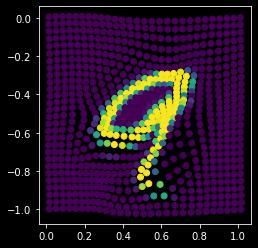

In [21]:
N = 71
plt.style.use("dark_background")
l = 0
a = l * iden + (1 - l) * phi
plt.axes().set_aspect('equal')
plt.scatter(a[N][1].flatten(), -a[N][0].flatten(), 
            c=fixed_image[N, 0].cpu().numpy().flatten())

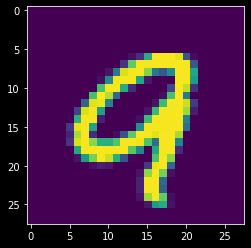

In [22]:
plt.imshow(fixed_image[N, 0].cpu().numpy())

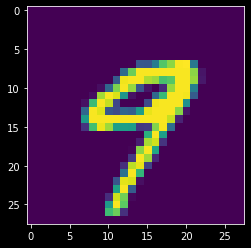

In [23]:
plt.imshow(moving_image[N, 0].cpu().numpy())

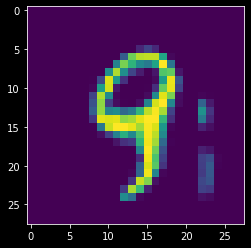

In [19]:
plt.imshow(net.warped_moving_image[N, 0].detach().cpu())

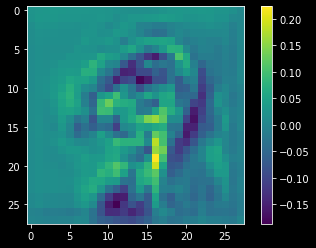

In [20]:
plt.imshow(net.mermaid_unit.m[N, 0].cpu().detach())
plt.colorbar()

In [18]:
def get_phi(a, b):
    net(a, b)
    return net.phi.detach().cpu()

In [19]:
phi1 = get_phi(moving_image, fixed_image)
phi2 = get_phi(fixed_image, moving_image)

/media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


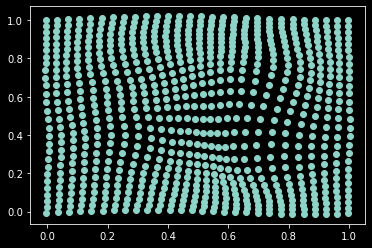

In [20]:
plt.scatter(phi1[N, 0], phi1[N, 1])

In [21]:
ident_hope = py_utils.compute_warped_image_multiNC(phi1, phi2, net.spacing, 1)

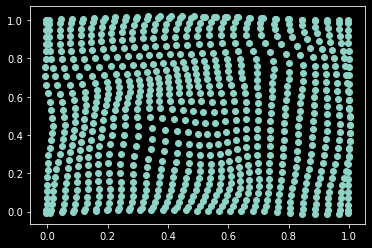

In [22]:
plt.scatter(ident_hope[N, 0], ident_hope[N, 1])

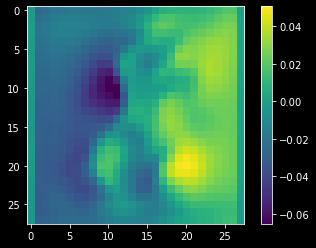

In [96]:
plt.imshow(ident_hope[N, 1] - iden[N, 1])
plt.colorbar()

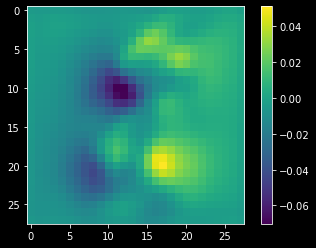

In [98]:
plt.imshow(phi2[N, 1] - iden[N, 1])
plt.colorbar()

In [27]:
net.phi.size()

torch.Size([128, 2, 28, 28])